To model the flight of a baseball, we have to make some modeling decisions.
To get started, we ignore any spin that might be on the ball, and the resulting Magnus force (see https://en.wikipedia.org/wiki/Magnus_effect). Under this assumption, the ball travels in a vertical plane, so we’ll run simulations in two dimensions, rather than three.  

Air resistance has a substantial effect on most projectiles in air, so we will include a drag force.  

To model air resistance, we’ll need the mass, frontal area, and drag coefficient of a baseball. Mass and diameter are easy to find. Drag coefficient is only a little harder; according to *The Physics of Baseball*
, the drag coefficient of a baseball is approximately 0.33 (with no
units).

In [49]:
from modsim_local import *
import numpy
from numpy import rad2deg
from numpy import deg2rad
from numpy import pi

Let’s simulate the flight of a baseball that is batted from home plate at an angle of 45° and initial speed 40 m/s. We’ll use the center of home plate as the origin, a horizontal x-axis (parallel to the ground), and a vertical y-axis (perpendicular to the ground). The initial height is 1 m.  

Got the mass and diameter from this wikipedia page (https://en.wikipedia.org/wiki/Baseball_(ball))

Here’s a `Params` object with the parameters we’ll need.

In [50]:
params = Params(
    x = 0,
    y = 1,
    angle = 45,
    speed = 40,
    
    mass = 145e-3,
    diameter = 73e-3,
    C_d = 0.33,
    
    rho = 1.2,
    g = 9.8,
    t_end = 10,
)

`make_system` uses `deg2rad` to convert `angle` to radians and `pol2cart` to compute the and components of the initial velocity.  

`init` is a `State` object with four state variables:  

`x` and `y` are the components of position.  

`vx` and `vy` are the components of velocity.  

When we call `System`, we pass `params` as the first argument, which means that the variables in `params` are copied to the new `System` object.

In [51]:
def make_system(params):
    
    #convert angle to radians
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    
    # make the initial state of the system
    init = State(x = params.x, y = params.y, vx = vx, vy = vy)
    
    # compute the frontal area
    area = pi*(params.diameter/2)**2
    
    return System(params, init = init, area = area)

Lets make the `System` object

In [52]:
system = make_system(params)

And here is the initial state:

In [53]:
show(system.init)

,state
x,0.000000
y,1.000000
vx,28.284271
vy,28.284271


# Drag Force

In [54]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

This function takes `V` as a `Vector` and returns `f_drag` as a Vector.

It uses `vector_mag` to compute the magnitude of `V`, and the drag equation to compute the magnitude of the drag force, `mag`.

Then it uses `vector_hat` to compute `direction`, which is a unit vector in the opposite direction of `V`.

Finally, it computes the drag force vector by multiplying `mag` and `direction`.

In [55]:
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = drag_force(V_test, system)
show(f_drag)

,component
x,-0.937574
y,-0.937574


The result is a `Vector` that represents the drag force on the baseball, in Newtons, under the initial conditions.

In [56]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

As usual, the parameters of the slope function are a time stamp, a `State` object, and a `System` object. We don’t use `t` in this example, but we can’t leave it out because when `run_solve_ivp` calls the slope function, it always provides the same arguments, whether they are needed or not.

`slope_func` unpacks the `State` object into variables `x`, `y`, `vx`, and `vy`. Then it packs vx and vy into a `Vector`, which it uses to compute acceleration due to drag, `a_drag`.

To represent acceleration due to gravity, it makes a `Vector` with magnitude `g` in the negative direction.

The total acceleration of the baseball, `A`, is the sum of accelerations due to gravity and drag.

The return value is a sequence that contains:

The components of velocity, `V.x` and `V.y`.

The components of acceleration,`A.x` and `A.y`.

These components represent the slope of the state variables, because `V` is the derivative of position and `A` is the derivative of velocity.

In [57]:
slope_func(0, system.init, system)

(28.284271247461902,
 28.284271247461902,
 -6.466030881564545,
 -16.266030881564546)

# Adding an Event Function

In [58]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

The event function takes the same parameters as the slope function, and returns the coordinate of position. When the coordinate passes through 0, the simulation stops.

As we did with `slope_func`, we can test `event_func` with the initial conditions.

In [59]:
event_func(0, system.init, system)

1.0

Now we run the simulation with the event function.

In [60]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

`results` is a `TimeFrame` with one row for each time step and one column for each of the state variables. Here are the first few rows.

In [75]:
results.head()

,x,y,vx,vy
0.000000,0.000000,1.000000,28.284271,28.284271
0.050049,1.407582,2.395354,27.965687,27.477967
0.100098,2.799468,3.750738,27.656886,26.686774
0.150147,4.176142,5.066897,27.357457,25.910015
0.200195,5.538058,6.344527,27.067026,25.147065


In [62]:
flight_time = results.index[-1]
flight_time

5.00488703486835

As we can see the flight time is around 5 seconds.

In [63]:
final_state = results.iloc[-1]
show(final_state)

,5.004887
x,9.931830e+01
y,-1.065814e-14
vx,1.416589e+01
vy,-2.205876e+01


The final value of `y` signifies its height at the end of the time of flight, around 0, as it should be. The final value of `x` is around 99.31830 meters which signifies its horizontal distance covered.

In [64]:
x_dist = final_state.x
y_dist = final_state.y
x_dist, y_dist

(99.3182962835221, -1.0658141036401503e-14)

Converting horizontal and vertical component of the velocities to vectors.

In [65]:
final_state = Vector(final_state.vx, final_state.vy)
show(final_state)

,component
x,14.165894
y,-22.058763


In [66]:
vector_mag(final_state), vector_angle(final_state)

(26.215674453237597, -0.999931783197589)

The final speed is about 26 m/s, which is substantially slower than the initial speed, 40 m/s, due to air drag.

# Visualizing Trajectories

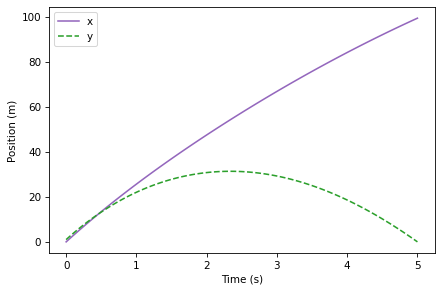

In [67]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

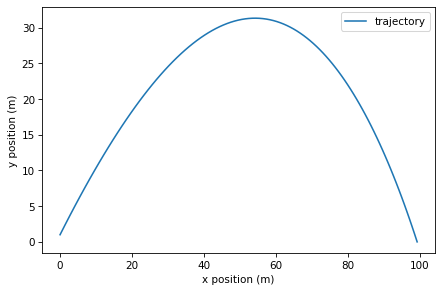

In [68]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

In [70]:
rad2deg(vector_angle(final_state))

-57.291870978212295

# Animating the Baseball

In [71]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

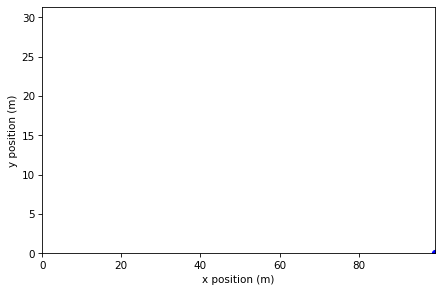

In [76]:
animate(results, draw_func)

# Summary

In this chapter I was introduced to `Vector` objects, which we use to represent position, velocity, and acceleration in two dimensions. We also represent forces using vectors, which make it easier to add up forces acting in different directions.